In [3]:
################################ 
# Connect to google drive      #
################################
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
####################
# Libraries        #
####################

import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim
import plotly.graph_objects as go    # for data visualisation
import plotly.express as px
import matplotlib.pyplot as plt

import seaborn as sns

import os
import glob

from sklearn.cluster import DBSCAN

In [32]:
##########################
# Functions              #
##########################

# initialize Nominatim API 
geolocator = Nominatim(user_agent="geoapiExercises")

# Function to get country, city, state
def getLocation(Latitude, Longitude):

    try: 
        location = geolocator.reverse(Latitude+","+Longitude)

        if 'error' in location.raw.keys():
            print("-----------None-----------")
            return pd.Series([np.nan, np.nan])

        # Display
    #     print(location.raw)

        address = location.raw['address']
    #     print(address)

    #     city = address.get('city', '')
        state = address.get('state', '')
        country = address.get('country', '')
    #     code = address.get('country_code')
    #     zipcode = address.get('postcode')
    #     print('City : ',city)
    #     print('State : ',state)
    #     print('Country : ',country)
    #     print('Country Code : ', code)
    #     print('Zip Code : ', zipcode)
        return pd.Series([country, state])
    
#     except GeocoderTimedOut:
#         print("-----------GeocoderTimedOut-----------")
#         return pd.Series([np.nan, np.nan])
    except:
        print("Something else went wrong")
        return pd.Series([np.nan, np.nan])
    
    
    
########### FOR PLOTTING    
def createDataObject(df, date, attributes):
    
    df_selected = df[df["Date"]==date]
    
    # Set hovering text as a new column
    df_selected['text'] = 'RH:=' + df_selected['RH'].astype(str) + ' <br>Temp_BB: '+ df_selected['Temp_BB'].astype(str)

    data = go.Scattergeo(
        lon = df_selected["Lon_GMTCO"],
        lat = df_selected["Lat_GMTCO"],
        text = df_selected["text"],
        mode = "markers",
        marker = dict(
            size = 10, #np.where(df_selected[attributes[1]].isna(), df_selected[attributes[1]], 0.0),       
            opacity = 0.8,
            reversescale = False, # set the reversescale and autocolorscale as True to enable the color of markers automatically changed
            autocolorscale = False,
            symbol = 'circle',
            line = dict(
                width = 1,
                color = 'blue'
            ),
            cmin = 0, # cmin/cmax == lower/upper bound of the color domain for the data points
            color = df_selected[attributes[0]],
            cmax = 2500, #df_selected[attributes[0]].max(), #
            colorbar_title = "Temperature (Kelvin)"
        )
    )
    return data
    

 ########### FOR PLOTTING 
def plotInteractive(df, attributes):
    uniqueDates = df["Date"].unique()
    
    # Create data object
    data_slider = []
    for date in uniqueDates:
        data_object = createDataObject(df, date, attributes)
        data_slider.append(data_object)

    fig = go.Figure(data = data_slider)
                    
    # Create step slider

    steps = []

    for idx in range(len(data_slider)):
        step = dict(method='restyle',
                    args=['visible', [False] * len(data_slider)],
                    label = '{}'.format(uniqueDates[idx]))
        step['args'][1][idx] = True
        steps.append(step)

    sliders = [dict(active=1, pad={"t":1}, steps=steps)]

    fig.update_layout(
    margin=dict(l=60, r=60, t=30, b=20),
    sliders=sliders,
    title = "Temperature measurements at locations identified as being flares in 2017", #"Temperature measurements at locations identified as not being flares in 2017",
    geo = dict(
        scope = "world", # ccope options: world, usa, europe, africa, north america, south america
        showland = True,
    ))
    

    return fig

In [8]:
###########################################
# Read the data from one file             #
###########################################
chunk = pd.read_csv("/content/gdrive/MyDrive/Gas Flaring Brainnwave/vnf_2017/vnf_2017_label_DBSCANFinalWith0.0002_COMPRESSED.csv", chunksize=100000)
df = pd.concat(chunk)

chunk_center = pd.read_csv("/content/gdrive/MyDrive/Gas Flaring Brainnwave/vnf_2017/vnf_2017_label_DBSCANFinalWith0.0002_onlyCenterMostPoint.csv", chunksize=100000)
df_center = pd.concat(chunk_center)

chunk_flareLabel= pd.read_csv("/content/gdrive/MyDrive/flare_labelled_data/flare_labelled_vnf_processed.csv", chunksize=100000)
df_flareLabel = pd.concat(chunk_flareLabel)

chunk_flareLabelAll = pd.read_csv("/content/gdrive/MyDrive/flare_labelled_data/flare_labelled_vnf_no_dbs.csv", chunksize=100000)
df_flareLabelAll = pd.concat(chunk_flareLabelAll)


In [9]:
df_flareLabel["Temp_BB_Diff"] = df_flareLabel["Temp_BB_Max_Label"] - df_flareLabel["Temp_BB_Min_Label"]
df_flareLabel = df_flareLabel.sort_values(by="Date")
df_flareLabel.describe()

,Unnamed: 0,Unnamed: 0.1,Lat_GMTCO,Lon_GMTCO,Temp_BB,RHI,RH,Area_BB,Cloud_Mask,Sample_M10,Label,Temp_BB_Max_Label,Temp_BB_Min_Label,Temp_BB_Mean_Label,Temp_BB_Std_Label,Temp_BB_Label_Day,Area_BB_Max_Label,Area_BB_Min_Label,Area_BB_Mean_Label,Area_BB_StdLabel,Area_BB_Label_Day,RHI_Max_Label,RHI_Min_Label,RHI_Mean_Label,RHI_StdLabel,RHI_Label_Day,Lat_GMTCO_Label,Lon_GMTCO_Label,Temp_BB_Diff
count,428526.000000,428526.000000,428526.000000,428526.000000,428526.000000,428526.000000,428526.000000,428526.000000,405756.000000,428526.000000,428526.000000,428526.000000,428526.000000,428526.000000,194883.000000,428526.000000,428526.000000,428526.000000,428526.000000,194883.000000,428526.000000,428526.000000,428526.000000,428526.000000,194883.000000,428526.000000,428526.000000,428526.000000,428526.000000
mean,226268.398207,226268.398207,4.369633,20.210355,1118.677226,3.953530,3.558057,50.586478,0.800146,1537.224661,226268.398207,1166.832384,1077.693844,1118.834718,81.252454,1144.068106,78.991716,36.483342,47.534366,29.862872,66.263925,6.780468,2.535143,3.586690,3.071465,5.616077,4.369633,20.210355,89.138540
std,129720.840149,129720.840149,23.822659,67.499588,212.233458,10.174158,9.103813,583.822150,1.111620,823.647630,129720.840149,251.728510,200.208281,204.667992,74.683485,231.634957,736.201048,578.385563,579.069983,74.438375,646.999508,30.634535,4.061445,5.501703,8.125886,23.015733,23.822659,67.499588,176.592085
min,0.000000,0.000000,-89.656425,-179.987122,402.000000,-0.107802,-0.249453,-14.357200,0.000000,1.000000,0.000000,402.000000,402.000000,402.000000,0.000000,402.000000,-2.765240,-5518.830000,-35.148579,0.000000,-14.357200,-0.020812,-3.775210,-0.020812,0.000000,-0.107802,-89.656425,-179.987122,0.000000
25%,113744.250000,113744.250000,-13.835737,-42.908850,968.000000,1.624240,1.409155,15.469125,0.000000,928.000000,113744.250000,1010.000000,911.000000,972.886765,33.501244,991.000000,18.445325,11.687000,16.617000,5.494963,17.133125,1.810993,1.333940,1.712582,0.454620,1.714490,-13.835737,-42.908850,0.000000
50%,227251.500000,227251.500000,5.479406,24.468328,1115.000000,2.351380,2.117420,27.274500,0.000000,1525.000000,227251.500000,1149.000000,1082.000000,1117.000000,63.639610,1133.000000,33.884400,20.458400,28.310052,12.798940,30.994800,2.782740,1.923715,2.476000,1.138817,2.566865,5.479406,24.468328,0.000000
75%,338438.750000,338438.750000,16.442626,65.994840,1235.000000,3.703015,3.456033,50.851250,1.000000,2125.000000,338438.750000,1279.000000,1196.000000,1233.500000,104.651804,1260.000000,67.261350,37.041875,50.810831,28.468932,59.771175,5.050223,2.737907,3.800957,2.728802,4.391967,16.442626,65.994840,113.000000
max,449942.000000,449942.000000,89.566116,179.984879,2500.000000,1093.050000,868.593000,241919.000000,3.000000,3200.000000,449942.000000,2500.000000,2500.000000,2500.000000,1185.818072,2500.000000,241919.000000,241919.000000,241919.000000,6270.323427,241919.000000,7300.230000,409.647000,409.647000,377.708973,2523.470000,89.566116,179.984879,2019.000000


In [10]:
df_center = df_center.sort_values(by="Date")
df_center.describe()

,Unnamed: 0,Lat_GMTCO,Lon_GMTCO,Temp_BB,RHI,RH,Area_BB,Cloud_Mask,Sample_M10,Label,Temp_BB_Max_Label,Temp_BB_Min_Label,Temp_BB_Mean_Label,Temp_BB_Std_Label,Temp_BB_Label_Day,Area_BB_Max_Label,Area_BB_Min_Label,Area_BB_Mean_Label,Area_BB_StdLabel,Area_BB_Label_Day,RHI_Max_Label,RHI_Min_Label,RHI_Mean_Label,RHI_StdLabel,RHI_Label_Day,Lat_GMTCO_Label,Lon_GMTCO_Label
count,449943.000000,449943.000000,449943.000000,449943.000000,449943.000000,449943.000000,449943.000000,426094.000000,449943.000000,449943.000000,449943.000000,449943.000000,449943.000000,206795.000000,449943.000000,449943.000000,449943.000000,449943.000000,206795.000000,449943.000000,449943.000000,449943.000000,449943.000000,206795.000000,449943.000000,449943.000000,449943.000000
mean,224971.000000,5.615337,19.188504,1126.437711,3.959302,3.560330,50.215793,0.794311,1537.541742,224971.000000,1177.797765,1083.078461,1126.827909,83.308311,1152.159636,79.193297,35.914629,47.053630,29.759880,65.996850,6.872600,2.511686,3.575539,3.073225,5.619826,5.615337,19.188504
std,129887.500422,24.495723,68.366969,225.738173,10.452265,9.346921,570.931708,1.110584,822.192502,129887.500422,271.358114,210.131996,218.584029,76.186606,244.619314,730.624540,564.638525,565.471627,80.495314,641.985623,31.214627,4.032141,5.569773,8.429869,23.597833,24.495723,68.366969
min,0.000000,-89.656425,-179.987122,402.000000,-0.107802,-0.249453,-14.357200,0.000000,1.000000,0.000000,402.000000,402.000000,402.000000,0.000000,402.000000,-2.765240,-5551.010000,-35.148579,0.000000,-14.357200,-0.020812,-3.803070,-0.020812,0.000000,-0.107802,-89.656425,-179.987122
25%,112485.500000,-13.408179,-44.016008,970.000000,1.606210,1.394325,15.163500,0.000000,930.000000,112485.500000,1012.000000,912.000000,974.500000,34.008629,993.000000,18.160800,11.378200,16.282857,5.278832,16.788300,1.801250,1.305780,1.695315,0.451746,1.697125,-13.408179,-44.016008
50%,224971.000000,6.421915,24.426792,1117.000000,2.338220,2.102500,27.001000,0.000000,1526.000000,224971.000000,1152.000000,1083.000000,1118.500000,64.969223,1135.000000,33.620600,20.214900,28.041800,12.563661,30.660500,2.777490,1.906010,2.460411,1.129784,2.551010,6.421915,24.426792
75%,337456.500000,19.143094,64.535934,1239.000000,3.690855,3.441765,50.478500,1.000000,2124.000000,337456.500000,1284.000000,1199.000000,1237.500000,107.967742,1265.000000,66.978300,36.701500,50.440600,28.168616,59.280050,5.062445,2.719760,3.785163,2.715406,4.374525,19.143094,64.535934
max,449942.000000,89.566116,179.984879,2500.000000,1165.460000,868.593000,241919.000000,3.000000,3200.000000,449942.000000,2500.000000,2500.000000,2500.000000,1185.818072,2500.000000,241919.000000,241919.000000,241919.000000,9251.672360,241919.000000,7300.230000,409.647000,446.078184,821.241186,2868.130000,89.566116,179.984879


In [11]:
df_flareLabel.shape

(428526, 34)

In [12]:
df_flareLabel.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'id_Key', 'Date_Mscan', 'Lat_GMTCO',
       'Lon_GMTCO', 'Temp_BB', 'RHI', 'RH', 'Area_BB', 'Cloud_Mask',
       'Sample_M10', 'Date', 'Above_1400K', 'Label', 'Temp_BB_Max_Label',
       'Temp_BB_Min_Label', 'Temp_BB_Mean_Label', 'Temp_BB_Std_Label',
       'Temp_BB_Label_Day', 'Area_BB_Max_Label', 'Area_BB_Min_Label',
       'Area_BB_Mean_Label', 'Area_BB_StdLabel', 'Area_BB_Label_Day',
       'RHI_Max_Label', 'RHI_Min_Label', 'RHI_Mean_Label', 'RHI_StdLabel',
       'RHI_Label_Day', 'Lat_GMTCO_Label', 'Lon_GMTCO_Label', 'osm_flare',
       'Temp_BB_Diff'],
      dtype='object')

In [13]:
unique_dates = df_flareLabel["Date"].unique()
#unique_dates

In [14]:
### Set the setting of the graph
sns.set(font_scale = 2)
sns.set(rc={'figure.figsize':(20,15)})

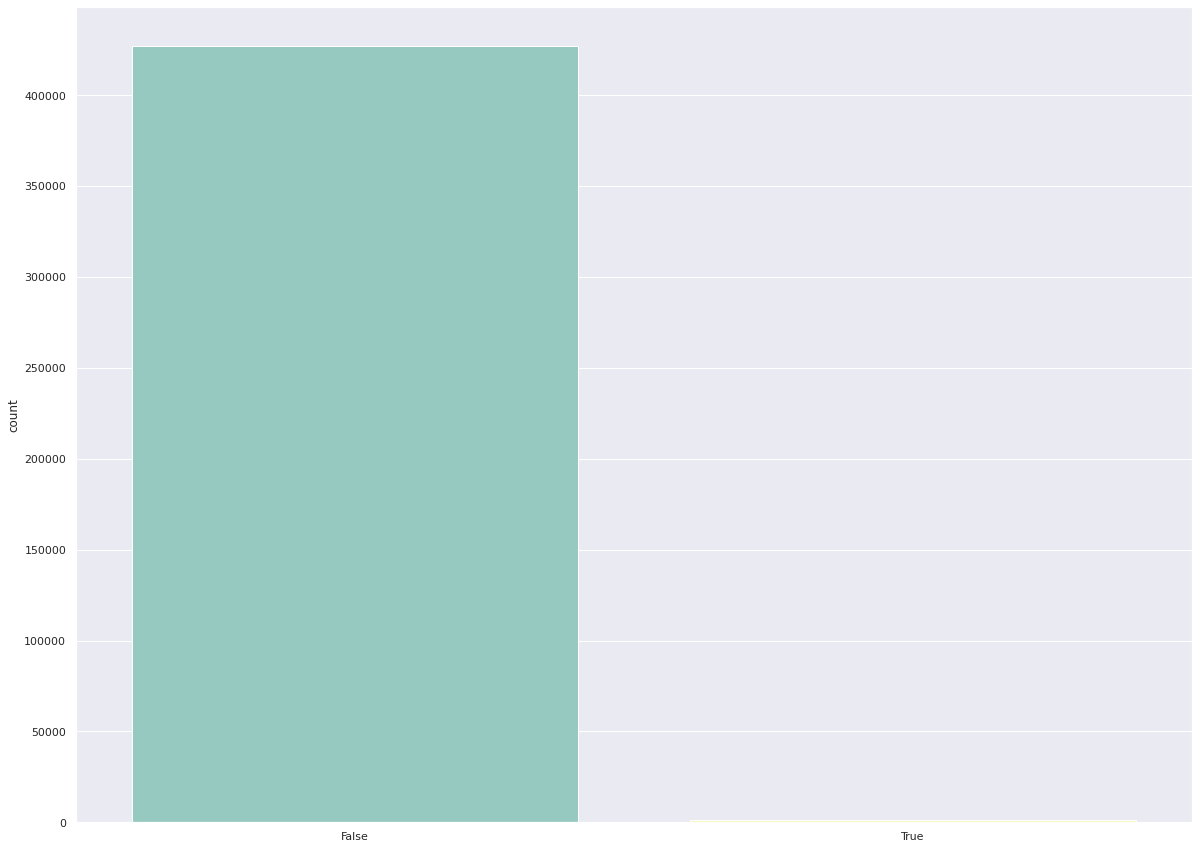

In [15]:
ax = sns.countplot(x="osm_flare", data=df_flareLabel, palette="Set3")
#ax.set_xticklabels(['Negative','Positive'])
ax.set_xlabel("")

plt.show()
#plt.hist(df_flareLabel["osm_flare"])

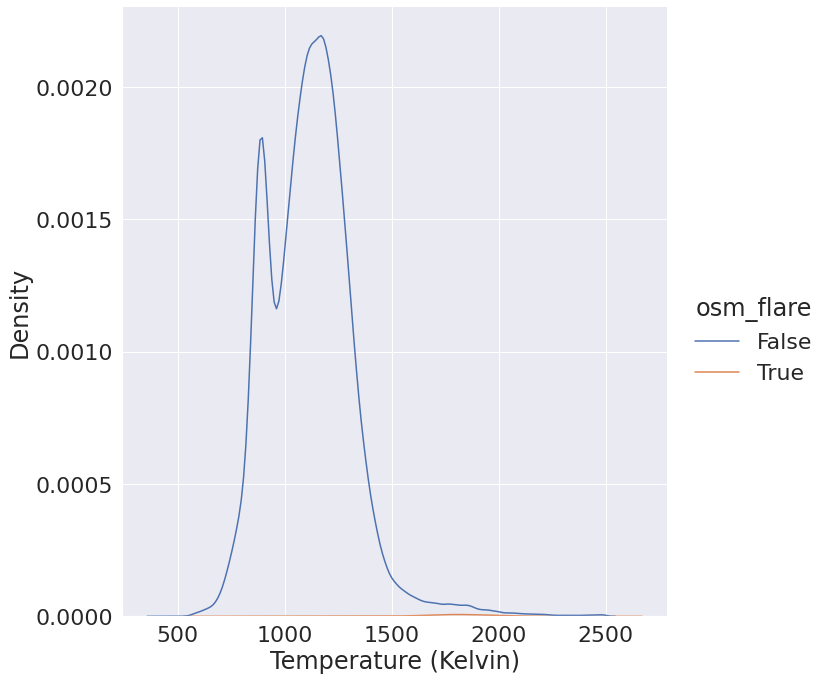

In [16]:
sns.set(font_scale = 2)

sns.displot(data=df_flareLabel, x="Temp_BB_Mean_Label", hue="osm_flare", kind="kde", height=10, aspect=1.0).set(xlabel="Temperature (Kelvin)")

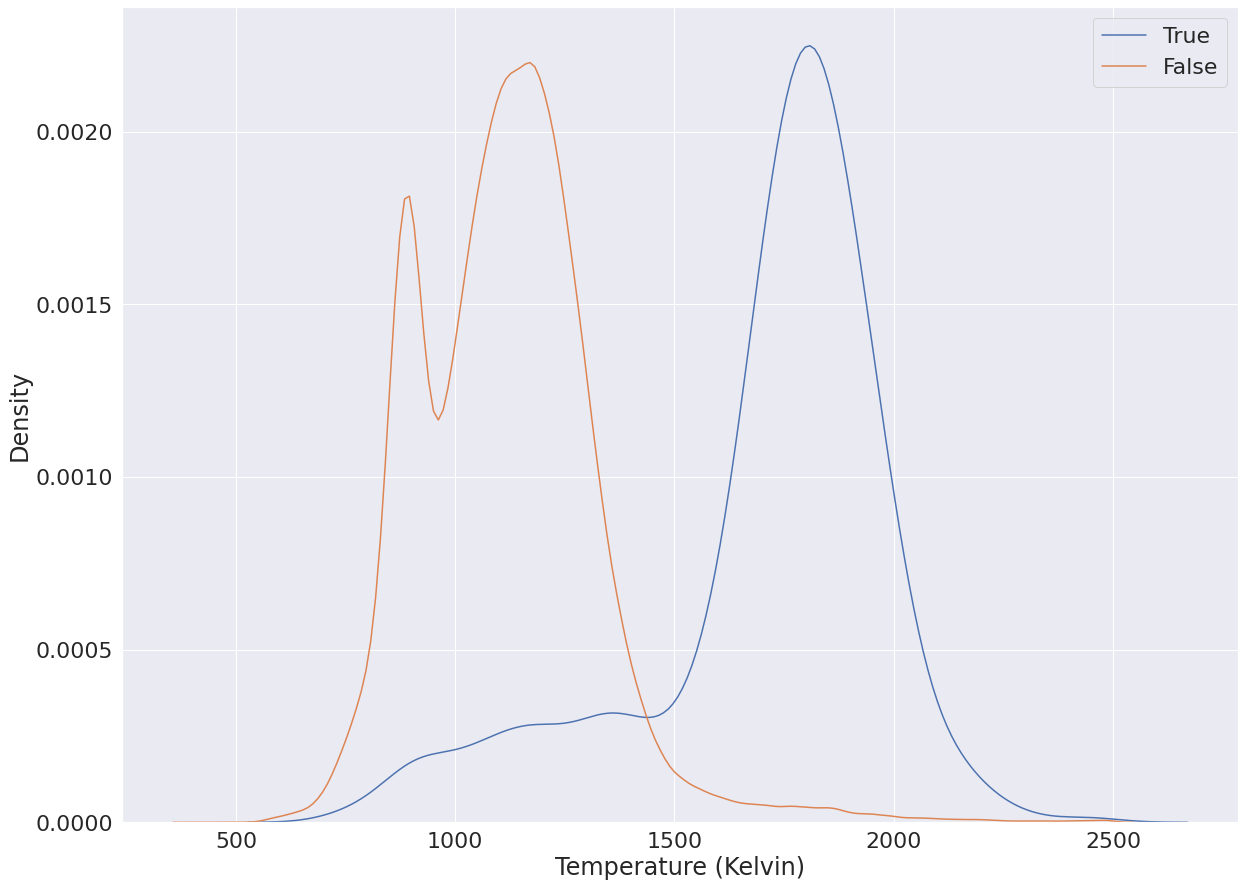

In [17]:
fig, ax = plt.subplots()
sns.kdeplot(data=df_flareLabel[df_flareLabel["osm_flare"]==True], x="Temp_BB_Mean_Label", ax=ax, label="True").set(xlabel="Temperature (Kelvin)")
sns.kdeplot(data=df_flareLabel[df_flareLabel["osm_flare"]==False], x="Temp_BB_Mean_Label", ax=ax, label="False")
ax.legend()


In [18]:
# sns.displot(data=df_flareLabel, x="Temp_BB_Mean_Label", height=10, aspect=1.0, kind="kde").set(xlabel="Temperature (Kelvin)")
# sns.displot(data=df_flareLabel[df_flareLabel["osm_flare"]==False], x="Temp_BB_Mean_Label", height=10, aspect=1.0, kind="kde").set(xlabel="Temperature (Kelvin)")



In [19]:
# fig, ax =plt.subplots(1,2)

# sns.displot(data=df_flareLabel[df_flareLabel["osm_flare"]==True], x="Temp_BB_Mean_Label", ax=ax[1], height=10, aspect=1.0, kind="kde").set(xlabel="Temperature (Kelvin)")
# sns.displot(data=df_flareLabel[df_flareLabel["osm_flare"]==False], x="Temp_BB_Mean_Label", ax=ax[0], height=10, aspect=1.0, kind="kde").set(xlabel="Temperature (Kelvin)")

# fig.show()

In [21]:
df_selected = df_flareLabel.copy()

unique_dates = df_selected["Date"].unique()
#df_selected = df_selected[(df_selected["Above_1400K"]) & (df_selected["Date"]==unique_dates[0])]
#df_selected = df_selected[df_selected["Above_1400K"]]
df_selected = df_selected[df_selected["Date"]==unique_dates[0]]

df_selected['text'] = 'RH:=' + df_selected['RH'].astype(str) + ' <br>RHI:=' + df_selected['RHI'].astype(str) + ' <br>Temp_BB: '+ df_selected['Temp_BB'].astype(str)+ ' <br>Area_BB: '+ df_selected['Area_BB'].astype(str)
fig = go.Figure(data = go.Scattergeo(
    lon = df_selected["Lon_GMTCO"],
    lat = df_selected["Lat_GMTCO"],
    text = df_selected["text"],
    mode = "markers",
    marker = dict(
        size = 10,
        opacity = 0.8,
        reversescale = True, # set the reversescale and autocolorscale as True to enable the color of markers automatically changed
        autocolorscale = True,
        symbol = 'x',
        line = dict(
            width = 1,
            color = 'rgba(102, 102, 102)'
        ),
        cmin = 0, # cmin/cmax == lower/upper bound of the color domain for the data points
        color = df_selected['Temp_BB'],
        cmax = df_selected['Temp_BB'].max(), #
        colorbar_title = "Temperature"
    )
))

fig.update_layout(
    title = "Temperature across the region in 2017",
    geo = dict(
        scope = "world", # ccope options: world, usa, europe, africa, north america, south america
        showland = True,
    )
)

fig.show()
#fig.write_html('first_figure.html', auto_open=True) #generate a HTML page that shows the scatter map

In [22]:
### To plot flare/no flare with different marker
df_selected = df_flareLabel.copy()

unique_dates = df_selected["Date"].unique()
#df_selected = df_selected[(df_selected["Above_1400K"]) & (df_selected["Date"]==unique_dates[0])]
#df_selected = df_selected[df_selected["Above_1400K"]]
df_selected = df_selected[df_selected["Date"]==unique_dates[0]]
df_selected_positive = df_selected[df_selected['osm_flare']==True]
df_selected_negative = df_selected[df_selected['osm_flare']==False]

df_selected['text'] = 'RH:=' + df_selected['RH'].astype(str) + ' <br>RHI:=' + df_selected['RHI'].astype(str) + ' <br>Temp_BB: '+ df_selected['Temp_BB'].astype(str)+ ' <br>Area_BB: '+ df_selected['Area_BB'].astype(str)

fig = go.Figure()

fig.add_trace(go.Scattergeo(
    lon = df_selected_positive["Lon_GMTCO"],
    lat = df_selected_positive["Lat_GMTCO"],
    text = df_selected["text"],
    mode = "markers",
    marker = dict(
        size = 8,
        opacity = 0.8,
        reversescale = True, # set the reversescale and autocolorscale as True to enable the color of markers automatically changed
        autocolorscale = True,
        symbol = 'circle',
        line = dict(
            width = 0.6,
            color = "red"#'rgba(102, 102, 102)'
        ),
        cmin = 0, # cmin/cmax == lower/upper bound of the color domain for the data points
        color = df_selected['Temp_BB'],
        cmax = df_selected['Temp_BB'].max(), #
        colorbar_title = "Temperature"
    )
))

fig.add_trace(go.Scattergeo(
    lon = df_selected_negative["Lon_GMTCO"],
    lat = df_selected_negative["Lat_GMTCO"],
    text = df_selected["text"],
    mode = "markers",
    marker = dict(
        size = 8,
        opacity = 0.8,
        reversescale = True, # set the reversescale and autocolorscale as True to enable the color of markers automatically changed
        autocolorscale = True,
        symbol = 'x',
        line = dict(
            width = 0.6,
            color = "blue" #'rgba(102, 102, 102)'
        ),
        cmin = 0, # cmin/cmax == lower/upper bound of the color domain for the data points
        color = df_selected['Temp_BB'],
        cmax = df_selected['Temp_BB'].max(), #
        colorbar_title = "Temperature"
    )
))

fig.update_layout(
    margin=dict(l=60, r=60, t=30, b=20),
    showlegend = False,
    title = "Temperature across the region in 2017",
    geo = dict(
        scope = "world", # ccope options: world, usa, europe, africa, north america, south america
        showland = True,
    )
)

fig.show()
#fig.write_html('first_figure.html', auto_open=True) #generate a HTML page that shows the scatter map

In [23]:
df_flareLabel = df_flareLabel.sort_values(by="Date", ignore_index=True)

In [33]:
### For positive
df_selected = df_flareLabel.copy()

unique_dates = df_selected["Date"].unique()

df_selected = df_selected[df_selected['osm_flare']==True].sort_values(by="Date", ignore_index=True)
#df_selected = df_selected[(df_selected["Above_1400K"]) & (df_selected["Date"]==unique_dates[0])]
df_selected.shape


STARTIDX = 1049
df_selected = df_selected.iloc[STARTIDX: df_selected.shape[0]]

plotInteractive(df_selected, ["Temp_BB_Max_Label", "Area_BB"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [31]:
### For negative
df_selected = df_flareLabel.copy()

unique_dates = df_selected["Date"].unique()

df_selected = df_selected[df_selected['osm_flare']==False].sort_values(by="Date", ignore_index=True)
#df_selected = df_selected[(df_selected["Above_1400K"]) & (df_selected["Date"]==unique_dates[0])]
df_selected.shape


STARTIDX = df_selected.shape[0] - 55000
df_selected = df_selected.iloc[STARTIDX: df_selected.shape[0]]

plotInteractive(df_selected, ["Temp_BB_Max_Label", "Area_BB"])

Output hidden; open in https://colab.research.google.com to view.